# Biosignal dataset analysis

Here I am going to analyze ECG data from three publicly available datasets:
- BIDMC
- Fantasia
- Capnobase
- custom dataset

extract features from the ECG signals and then use those features to cluster the signals into groups. While this won't provide medical classifications, it can give an idea of the variety in the signals.

For the feature extraction, we can use the following:

Heart Rate: Calculated based on the RR intervals in the ECG.

QRS Duration: The duration of the QRS complex.

QT Interval: The interval between the start of the Q wave and the end of the T wave.

PR Interval: The interval between the start of the P wave and the start of the QRS complex.

For clustering, we can use the K-means clustering algorithm.

Here are the steps we'll take:

Feature Extraction:
- Extract features like Heart Rate, QRS Duration, QT Interval, and PR Interval from the ECG signals.
  
Clustering:
- Apply the K-means clustering algorithm to the extracted features to cluster the ECG signals into groups.
  
Visualization:
- Visualize the clusters using a scatter plot to understand the distribution.

Electrocardiogram (ECG) signals offer a wealth of information about the heart's electrical activity. From raw ECG signals, various features can be extracted, and these features can provide insights into the physiological and pathological conditions of the heart. Here's a list of commonly extracted features:

1. **Time-domain features**:
    - **RR intervals (or NN intervals)**: Time intervals between consecutive R-peaks.
    - **Heart Rate (HR)**: Derived from the RR intervals.
    - **QRS duration**: The width of the QRS complex, indicating ventricular depolarization.
    - **P duration**: Duration of the atrial depolarization.
    - **PR interval**: Duration from the onset of the P wave to the onset of the QRS complex.
    - **QT interval**: Duration from the onset of the Q wave to the end of the T wave.
    - **T duration**: Duration of the ventricular repolarization.
    - **ST segment duration**: The duration between the end of the S wave and the start of the T wave.
    - **Heart Rate Variability (HRV)**: Variability in the RR intervals.

2. **Frequency-domain features** (often derived using Fast Fourier Transform or power spectral density analysis):
    - **High frequency (HF) components**: Power in the high-frequency band (usually 0.15 to 0.4 Hz), associated with respiratory influences.
    - **Low frequency (LF) components**: Power in the low-frequency band (usually 0.04 to 0.15 Hz), associated with both sympathetic and parasympathetic influences.
    - **Very low frequency (VLF) components**: Power in the very low-frequency band (usually below 0.04 Hz).
    - **LF/HF ratio**: Ratio of LF power to HF power, often used as an indicator of the balance between sympathetic and parasympathetic activity.

3. **Morphological features**:
    - **Amplitudes** of the P wave, QRS complex, and T wave.
    - **ST segment level**: The level of the ST segment, which can be a marker for myocardial ischemia.
    - **T wave alternans**: Alternating pattern of the T wave, a potential predictor of ventricular arrhythmias.
    - **Presence or absence of U waves**: Small waves that may appear after the T wave.

4. **Wavelet-based features**: Using wavelet transform, specific scales or coefficients can be extracted, which can capture subtle changes in the ECG signal.

5. **Higher-order statistical features**: Skewness, kurtosis, etc., of the raw signal or derived intervals.

6. **Nonlinear features**:
    - **Poincaré plot descriptors**: Shape and variability descriptors from scatter plots of RR intervals.
    - **Entropy measures**: Approximate, sample, or multiscale entropy indicating the complexity of the ECG signal.
    - **Detrended fluctuation analysis**: Evaluating the fractal scaling properties of the ECG signal.

7. **Geometric features**:
    - **Angle between consecutive QRS vectors**: Can be useful in diagnosing certain types of arrhythmias.
    - **Magnitude and direction of the mean QRS vector**.

These features can be used in various applications, including diagnosing cardiac diseases, predicting cardiac events, stress analysis, sleep quality assessment, and many others. The choice of features largely depends on the specific application and the dataset at hand.


![Alt text](https://ecgwaves.com/wp-content/uploads/2018/01/ekg-ecg-interpretation-p-qrs-st-t-wave.jpg "a title")


In [319]:
import wfdb
from wfdb import processing
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from biosppy.signals import ecg
from tqdm import tqdm
import scipy.signal as signal

In [320]:
database_to_frequency = {
    'BIDMC': 125,
    'Fantasia': 250,
    'Capnobase': 300,
    'custom': 450
}

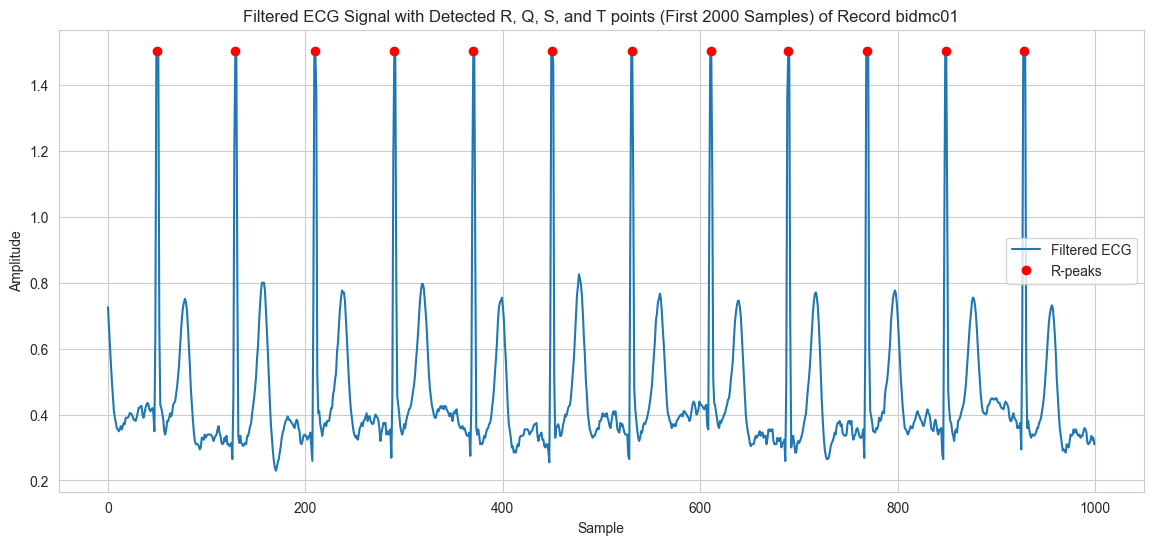

In [321]:
ecg_signal = np.array(df_bidmc['ECG_Signal'].iloc[0])
# detect peaks
#peaks, similarity = detect_peaks(ecg_signal, threshold=0.3)
out = ecg.ecg(signal=ecg_signal, sampling_rate=125, show=False)
peaks = out['rpeaks']
#print(peaks[:8])

# Plot the ECG signal with detected R, Q, S, and T points
plt.figure(figsize=(14, 6))
plt.plot(ecg_signal[:1000], label="Filtered ECG")
#plt.plot(p_points[:8], smoothed_signal[p_points[:8]], 'yo', label="P-points")
plt.plot(peaks[:12], ecg_signal[peaks[:12]], 'ro', label="R-peaks")
#plt.plot(q_points[:8], smoothed_signal[q_points[:8]], 'bo', label="Q-points")
#plt.plot(s_points[:8], smoothed_signal[s_points[:8]], 'go', label="S-points")
#plt.plot(t_points[:8], smoothed_signal[t_points[:8]], 'mo', label="T-points")
plt.title("Filtered ECG Signal with Detected R, Q, S, and T points (First 2000 Samples) of Record bidmc01")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

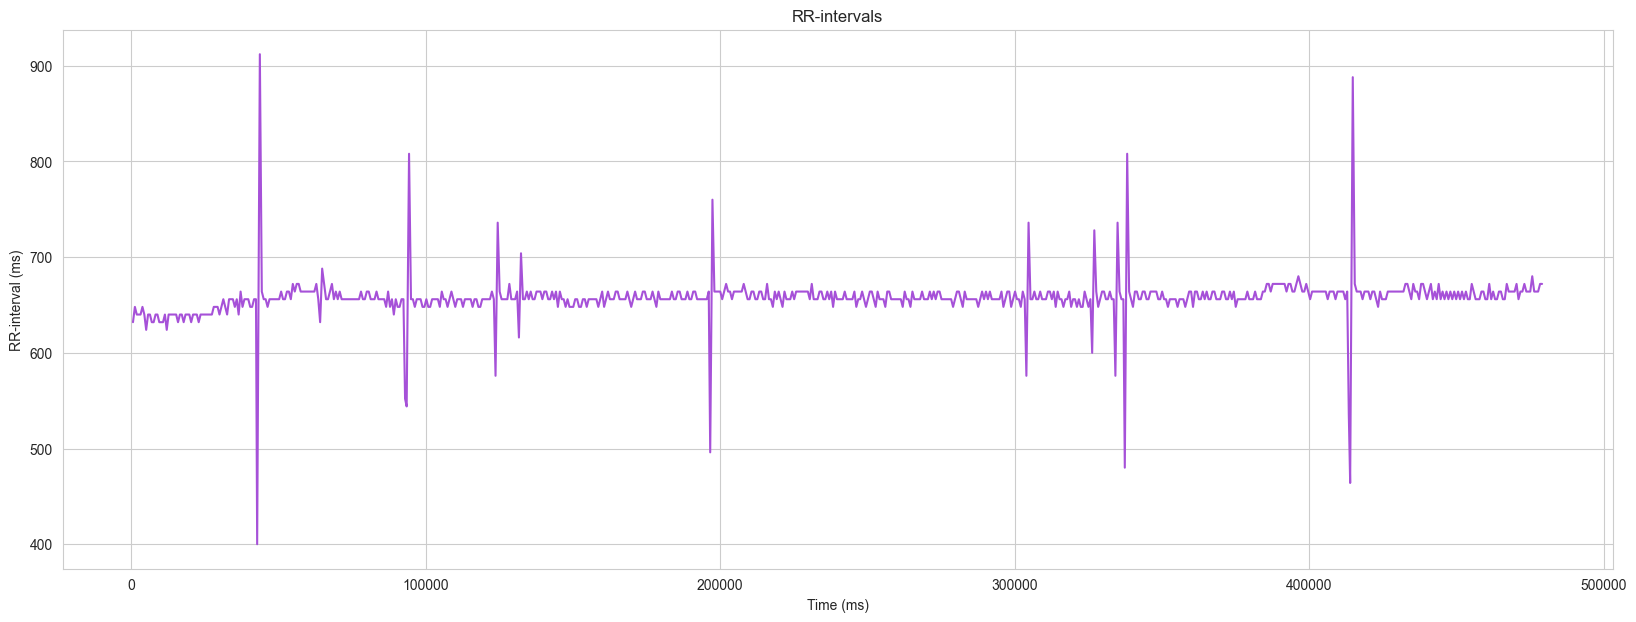

In [322]:
# RR-intervals are the differences between successive peaks
rr_intervals_samples = np.diff(peaks)
delta_t = 1000 / 125
rr_intervals_ms = rr_intervals_samples * delta_t

# plot RR-intervals
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(np.cumsum(rr_intervals_ms), rr_intervals_ms, label="RR-interval", color="#A651D8")
plt.show()

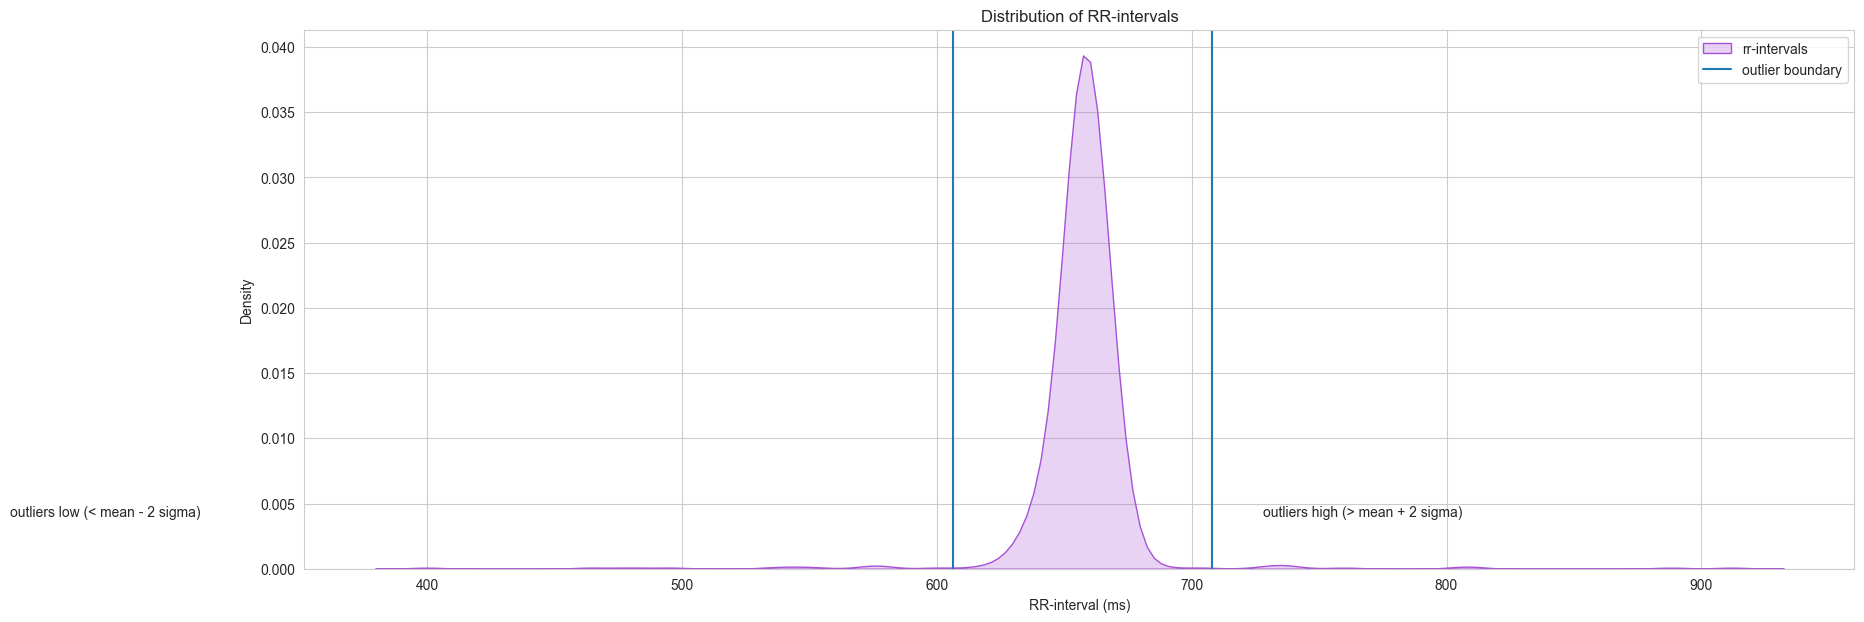

In [323]:
plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(rr_intervals_ms, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(rr_intervals_ms) - 2 * np.std(rr_intervals_ms)
outlier_high = np.mean(rr_intervals_ms) + 2 * np.std(rr_intervals_ms)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)")

plt.xlabel("RR-interval (ms)")
plt.ylabel("Density")

plt.legend()
plt.show()

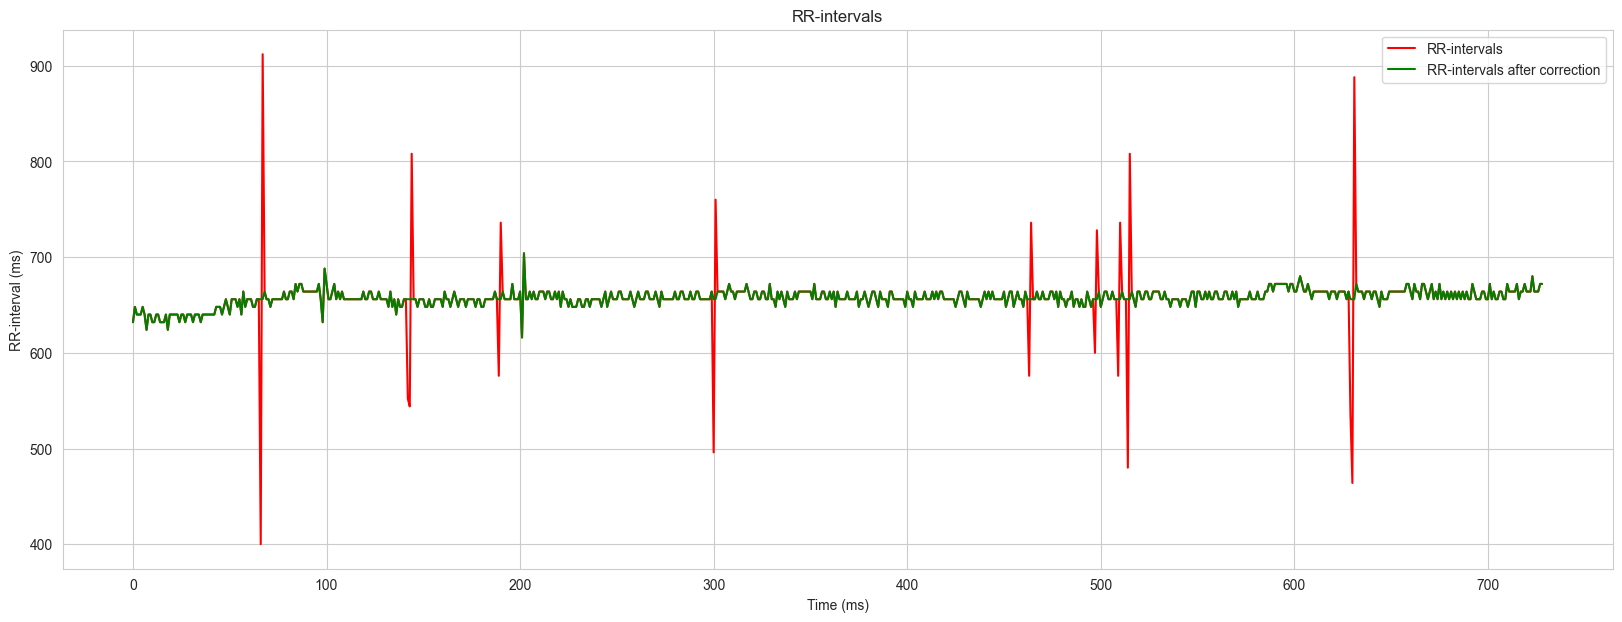

In [324]:
from scipy.stats import zscore

plt.figure(figsize=(20, 7))

rr_corrected = rr_intervals_ms.copy()
rr_corrected[np.abs(zscore(rr_intervals_ms)) > 2] = np.median(rr_intervals_ms)

plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(rr_intervals_ms, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()

RMSSD

The most popular HRV metric is the Root Mean Square of Successive Differences or RMSSD. **It’s a measure for how much variation there exists in the heart rate. In a healthy heart, there is a natural variation, which is due to a balance between the sympathetic nervous system (SNS) and parasympathetic parts (PSNS) of the Autonomous Nervous System. If your body experiences stress, then the sympathetic system will activate, to prepare for fight or flight behaviour, and your heartrate will increase. The parasympathetic controls your body’s “rest and digest” responses and is associated with recovery. Parasympathetic activation conserves energy, constricts pupils, aids digestion, and slows your heart rate. These two parts of the nervous system are normally in a healthy balance, causing a natural variation in heart. If this balance is disturbed for any reason, this variance will change. A lower RMSSD is associated with stress and various illnesses.

Other metrics

RMSSD is often used as the score that represents your “HRV”. It’s the most important one and it’s used in a lot of research. Here’s a list of other metrics, that are used for time domain analysis:

Mean RR: mean of RR-interval

SDNN: standard deviation of the RR-intervals

Mean HR: the well-known mean heartrate, measured in Beats Per Minute

STD HR: standard deviation of the heartrate

Min HR: lowest heartrate

Max HR: highest heartrate

NN50: The number of pairs of successive RR-intervals that differ by more than 50 ms. (normal RR-intervals are often called NN-intervals)

PNN50: The proportion of NN50 divided by the total number of RR-intervals.

In [325]:
# functions
def derive_mean_heart_rate(signal, fs):
    try:
        out = ecg.ecg(signal=signal, sampling_rate=fs, show=False)
        heart_rates = out['heart_rate']
        
        return np.mean(heart_rates)
    except:
        return np.nan, np.nan

In [326]:
# Path to the BIDMC dataset
dataset_path = '/Users/lanacaldarevic/workspace/phd/biosignal_research/data/bidmc-ppg-and-respiration-dataset-1.0.0'
records_path = '/Users/lanacaldarevic/workspace/phd/biosignal_research/data/bidmc-ppg-and-respiration-dataset-1.0.0/RECORDS'

def read_records_path(records_path):
    with open(records_path) as f:
        records = f.readlines()
    records = [record.strip() for record in records]
    return records


# List of all records in the dataset
records = read_records_path(records_path)
print("Number of records: {}".format(len(records)))
print(f"Records: {records}")

Number of records: 53
Records: ['bidmc01', 'bidmc02', 'bidmc03', 'bidmc04', 'bidmc05', 'bidmc06', 'bidmc07', 'bidmc08', 'bidmc09', 'bidmc10', 'bidmc11', 'bidmc12', 'bidmc13', 'bidmc14', 'bidmc15', 'bidmc16', 'bidmc17', 'bidmc18', 'bidmc19', 'bidmc20', 'bidmc21', 'bidmc22', 'bidmc23', 'bidmc24', 'bidmc25', 'bidmc26', 'bidmc27', 'bidmc28', 'bidmc29', 'bidmc30', 'bidmc31', 'bidmc32', 'bidmc33', 'bidmc34', 'bidmc35', 'bidmc36', 'bidmc37', 'bidmc38', 'bidmc39', 'bidmc40', 'bidmc41', 'bidmc42', 'bidmc43', 'bidmc44', 'bidmc45', 'bidmc46', 'bidmc47', 'bidmc48', 'bidmc49', 'bidmc50', 'bidmc51', 'bidmc52', 'bidmc53']


In [327]:
# load BIDMC dataset

age_pattern = r'<age>:\s*(\d+)'
sex_pattern = r'<sex>:\s*([MF])'

def extract_data(record_name):
    # Read the record using the wfdb library
    record = wfdb.rdrecord(record_name)
    
    # Extract ECG signal
    # Assuming the ECG signal is the first signal in the record
    ecg_signal = record.p_signal[:, 4].tolist()  #sig_name': ['RESP,', 'PLETH,', 'V,', 'AVR,', 'II,'],
    # 2 - V lead
    # 3 - AVR lead
    # 4 - II lead
    
    # Extract age and gender from the record's comments
    age = None
    gender = None
    for comment in record.comments:
        if 'age' in comment:
            try:
                age = int(re.search(age_pattern, comment).group(1))
            except:
                age = None
        if 'sex' in comment:
            try:
                gender = re.search(sex_pattern, comment).group(1)
            except:
                gender = None
                
    record = wfdb.rdrecord(f"{record_name}n")
    
    #heart_rates = record.p_signal[:,0]

    return ecg_signal, age, gender

In [330]:
# Lists to store extracted data
all_ecg_signals = []
all_ages = []
all_genders = []
all_hr = []
all_hrv = []

for record in records:
    ecg_signal, age, gender = extract_data(os.path.join(dataset_path, record))
    #hr2, hrv = derive_mean_heart_rate(ecg_signal, 125)
    all_ecg_signals.append(ecg_signal)
    all_ages.append(age)
    all_genders.append(gender)
    #all_hr.append(hr)
    #all_hrv.append(hrv)

# Create a pandas DataFrame
df_bidmc = pd.DataFrame({
    'Record': records,
    'ECG_Signal': all_ecg_signals,
    #'Age': all_ages,
    #'Gender': all_genders,
    #'Heart_Rate': all_hr,
    #'HRV': all_hrv
})

df_bidmc['Database'] = 'BIDMC'

# Save the DataFrame to a CSV file
df_bidmc.to_parquet('bidmc_data.parquet')

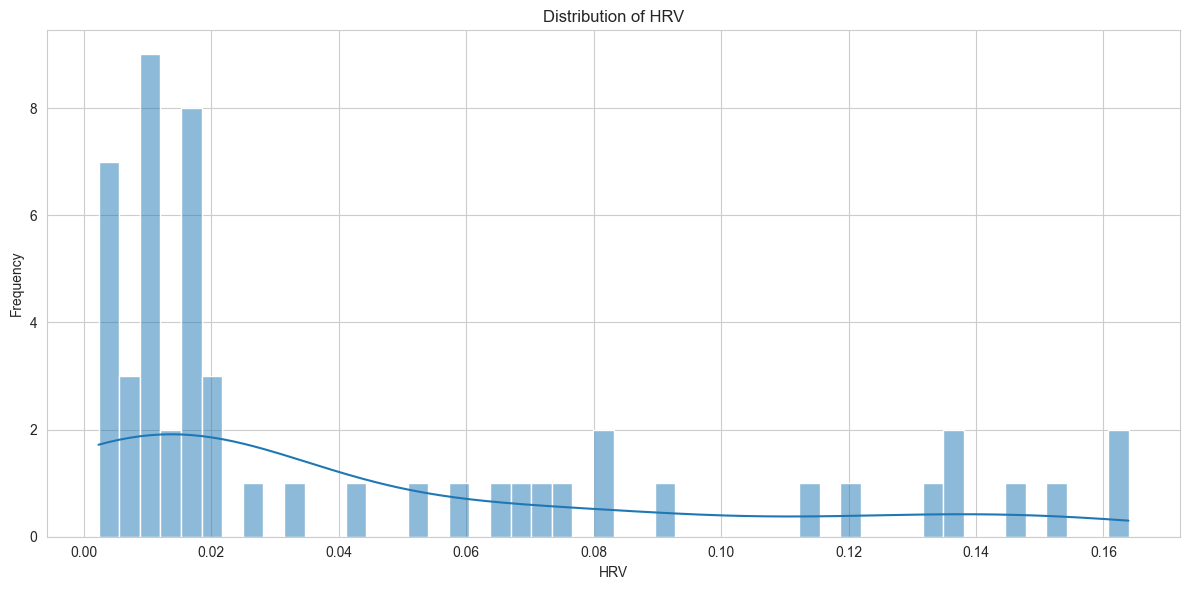

In [264]:
# Plot the distribution of HRV
plt.figure(figsize=(12, 6))
sns.histplot(df_bidmc['HRV'].dropna(), kde=True, bins=50)
plt.title("Distribution of HRV")
plt.xlabel("HRV")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [331]:
# fantasia

files = os.listdir("/Users/lanacaldarevic/workspace/phd/biosignal_research/data/fantasia-database-1.0.0")
files = [s.replace('.dat', '') for s in files if ".dat" in s]

# Regular expression patterns to extract age and sex
age_pattern = r'Age:\s*(\d+)'
sex_pattern = r'Sex:\s*([MF])'

# Extract age and sex

patients_fantasia = []
all_ecg_signals = []
all_ages = []
all_genders = []
all_hr = []
all_hrv = []

for i, participant in enumerate(files):
    patients_fantasia.append(participant)

    data, info = wfdb.rdsamp("/Users/lanacaldarevic/workspace/phd/biosignal_research/data/fantasia-database-1.0.0/" + participant)
    age = re.search(age_pattern, info['comments'][0]).group(1)
    sex = re.search(sex_pattern, info['comments'][0]).group(1) 

    # Get signal
    data = pd.DataFrame(data, columns=info["sig_name"])
    ecg_signal = data['ECG'].to_list()
    
    #hr, hrv = derive_mean_heart_rate(ecg_signal, fs=250)
    
    all_ecg_signals.append(smoothed_signal)
    all_ages.append(age)
    all_genders.append(sex)
    #all_hr.append(hr)
    #all_hrv.append(hrv)


df_fantasia = pd.DataFrame({
    'Record': patients_fantasia,
    'ECG_Signal': all_ecg_signals,
   # 'Age': all_ages,
   # 'Gender': all_genders,
   # 'Heart_Rate': all_hr,
   # 'HRV': all_hrv
})

df_fantasia['Database'] = 'Fantasia'

# Save the DataFrame to a CSV file
df_fantasia.to_parquet('fantasia_data.parquet')  

In [332]:
# capnobase
from glob import glob
path = '/Users/lanacaldarevic/workspace/phd/biosignal_research/data/capnobase/csv'
ext = "*signal.csv"
all_csv_files = [file for path, subdir, files in os.walk(path) for file in glob(os.path.join(path, ext))]

patients_capnobase = []
all_ecg_signals = []
all_ages = []
all_genders = []
all_hr = []
all_hrv = []

for file in all_csv_files:
    experiment = file.split("/")[-1].split("_signal")[0]
    patient = experiment.split("_")[0]
    
    try:
        df = pd.read_csv(file, usecols=['ecg_y'])
        ecg_signal = df['ecg_y'].to_list()
        all_ecg_signals.append(ecg_signal)
        patients_capnobase.append(patient)
        
        #hr, hrv = derive_mean_heart_rate(ecg_signal, fs=300)
 
        meta_path = f'/Users/lanacaldarevic/workspace/phd/biosignal_research/data/capnobase/csv/{experiment}_meta.csv'
        df = pd.read_csv(meta_path, usecols=['subject_gender', 'subject_age'])

        all_ages.append(df['subject_age'][0])
        all_genders.append(df['subject_gender'][0])
        #all_hr.append(hr)
        #all_hrv.append(hrv)
    except:
        break  

df_capnobase = pd.DataFrame({
    'Record': patients_capnobase,
    'ECG_Signal': all_ecg_signals,
    #'Age': all_ages,
    #'Gender': all_genders,
    #'Heart_Rate': all_hr,
    #'HRV': all_hrv
})

df_capnobase['Database'] = 'Capnobase'

# Save the DataFrame to a CSV file
df_capnobase.to_parquet('capnobase_data.parquet', index=False)     

In [102]:
# Alexandra dataset
import pickle
with open(r"/Users/lanacaldarevic/workspace/phd/biosignal_research/data/data_full.pickle", "rb") as input_file:
    data = pickle.load(input_file)
    
patients_custom = []
all_ecg_signals = []
all_hr = []
all_hrv = []

for patient, signals in data.items():
    patients_custom.append(patient)
    all_ecg_signals.append(signals[0])
    hr, hrv = derive_mean_heart_rate(signals[0], fs=450)
    all_hr.append(hr)
    all_hrv.append(hrv)
    # lead II


df_custom = pd.DataFrame({
    'Record': patients_custom,
    'ECG_Signal': all_ecg_signals,
    'Heart_Rate': all_hr,
    'HRV': all_hrv
    })

df_custom['Age'] =  np.nan
df_custom['Gender'] = np.nan
df_custom['Database'] = 'custom'

In [104]:
df = pd.concat([df_bidmc, df_fantasia, df_capnobase, df_custom])

In [105]:
df.to_csv("ecg_complete.csv", index=False)

In [318]:
df[['ECG_Signal']].to_parquet("ecg_signals.parquet")

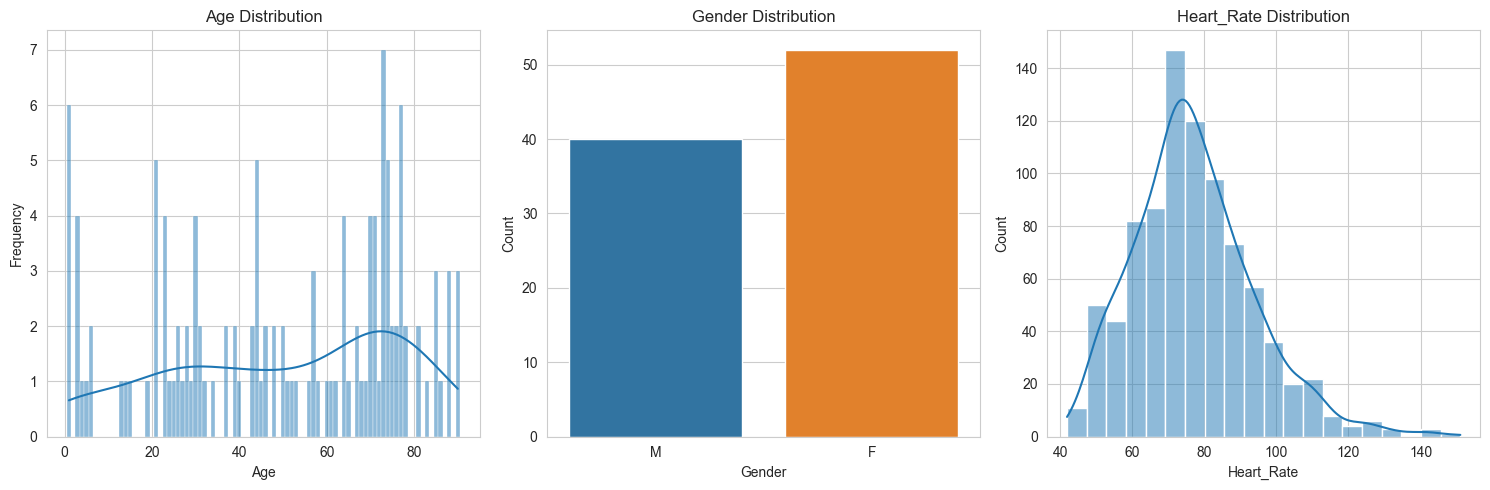

In [106]:
# Set the style for seaborn
sns.set_style("whitegrid")

# Create a figure with two subplots: one for age distribution and one for gender distribution
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Plot the age distribution
sns.histplot(df['Age'], bins=20, kde=True, ax=ax[0])
ax[0].set_title('Age Distribution')
ax[0].set_xlabel('Age')
ax[0].set_ylabel('Frequency')

# Plot the gender distribution
sns.countplot(x='Gender', data=df, ax=ax[1])
ax[1].set_title('Gender Distribution')
ax[1].set_xlabel('Gender')
ax[1].set_ylabel('Count')

# Plot the Heart_Rate distribution
sns.histplot(df['Heart_Rate'], bins=20, kde=True, ax=ax[2])
ax[2].set_title('Heart_Rate Distribution')
ax[2].set_xlabel('Heart_Rate')
ax[2].set_ylabel('Count')

# Display the plots
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Randomly select a few ECG signals to visualize
sample_records = df.sample(n=5, random_state=42)

# Create a figure for ECG signal plots
plt.figure(figsize=(15, 10))

# Plot each selected ECG signal
for idx, (record, signal, signal_db) in enumerate(zip(sample_records['Record'], sample_records['ECG_Signal'], sample_records['Database'])):
    plt.subplot(5, 1, idx + 1)
    plt.plot(np.arange(len(signal))/database_to_frequency[signal_db], signal)      
    plt.title(f'ECG Signal for {record}')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude')
    plt.tight_layout()

plt.show()

In [107]:
df.head()

,Record,ECG_Signal,Age,Gender,Heart_Rate,HRV,Database,QRS_Duration
0,bidmc01,"[0.7254772105499813, 0.6705965828174644, 0.609...",88.0,M,91.318087,1.938729,BIDMC,82.0
1,bidmc02,"[0.744148552659688, 0.7402264473403118, 0.7402...",65.0,M,91.066514,1.697693,BIDMC,82.0
2,bidmc03,"[0.43966109312054313, 0.42980742934729727, 0.4...",46.0,F,76.638242,9.313914,BIDMC,98.0
3,bidmc04,"[1.0215604262697697, 1.0960718157329732, 1.005...",78.0,M,92.397126,3.940514,BIDMC,80.0
4,bidmc05,"[0.7207022311436104, 0.7050734163247091, 0.685...",73.0,F,98.209965,0.978071,BIDMC,76.0


In [ ]:
# custom fantasia capnobase search_window=20
# bidmc = 15

In [ ]:
def detect_qst_points_safe(r_peaks, ecg_signal, search_window=30):
    """Detect P, Q, S, and T points for each R-peak with safety checks."""
    p_points = []
    q_points = []
    s_points = []
    t_points = []
    for r in r_peaks:
        # Ensure we don't go out of bounds
        start_q_search = max(0, r - search_window)
        end_t_search = min(len(ecg_signal) - 1, r + 2 * search_window)

        # Safety check: Skip this R-peak if the search interval is invalid
        if start_q_search >= end_t_search:
            continue

        # Search for Q point (local minimum before the R-peak)
        q = r - np.argmin(ecg_signal[start_q_search:r][::-1]) - 1
        q_points.append(q)
        
        # Search for P point (local maximum before the Q-point, within a window)
        start_p_search = max(0, q - search_window)
        p = q - np.argmax(ecg_signal[start_p_search:q][::-1]) - 1
        p_points.append(p)

        # Search for S point (local minimum after the R-peak)
        s = r + np.argmin(ecg_signal[r:end_t_search])
        s_points.append(s)

        # Search for T point (local maximum after the S-point)
        t = s + np.argmax(ecg_signal[s:end_t_search])
        t_points.append(t)

    return p_points, q_points, s_points, t_points

def compute_intervals(p_points, q_points, r_peaks, s_points, t_points, fs=125.0):
    """Compute QRS, QT, and approximate PR intervals."""
    # Compute intervals in samples
    qrs_intervals_samples = np.array(s_points) - np.array(q_points)
    qt_intervals_samples = np.array(t_points) - np.array(q_points)
    pr_intervals_samples = np.array(r_peaks) - np.array(p_points)
    
    # Convert intervals from samples to milliseconds
    qrs_intervals_ms = (np.array(qrs_intervals_samples) / fs) * 1000
    qt_intervals_ms = (np.array(qt_intervals_samples) / fs) * 1000
    pr_intervals_ms = (np.array(pr_intervals_samples) / fs) * 1000
    
    return qrs_intervals_ms, qt_intervals_ms, pr_intervals_ms

In [220]:
ecg_signal = df_capnobase['ECG_Signal'].iloc[0]
fs = 300
lowpass = 100
highpass = 0.01

a, b = signal.butter(6, (highpass, lowpass), btype='bandpass', analog=True)
filtered_signal = signal.lfilter(b, a, ecg_signal)
smoothed_signal = signal.cspline1d(filtered_signal, lamb=10)
#smoothed_signal = np.array(ecg_signal)
out = ecg.ecg(signal=smoothed_signal, sampling_rate=fs, show=False)
r_peaks = out['rpeaks']

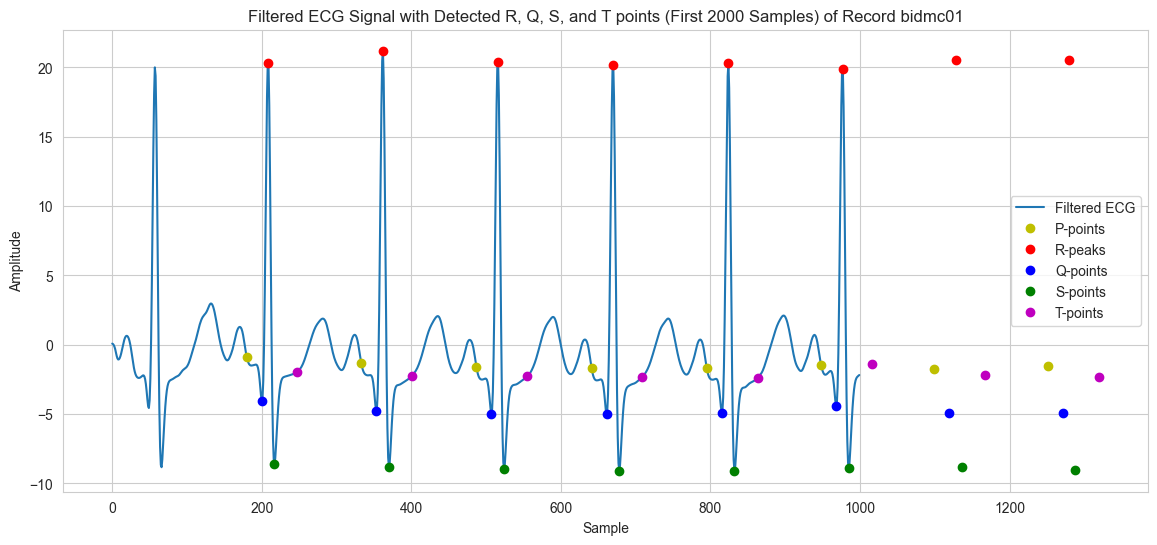

In [225]:
p_points, q_points, s_points, t_points = detect_qst_points_safe(r_peaks, smoothed_signal, search_window=20)

# Plot the ECG signal with detected R, Q, S, and T points
plt.figure(figsize=(14, 6))
plt.plot(smoothed_signal[:1000], label="Filtered ECG")
plt.plot(p_points[:8], smoothed_signal[p_points[:8]], 'yo', label="P-points")
plt.plot(r_peaks[:8], smoothed_signal[r_peaks[:8]], 'ro', label="R-peaks")
plt.plot(q_points[:8], smoothed_signal[q_points[:8]], 'bo', label="Q-points")
plt.plot(s_points[:8], smoothed_signal[s_points[:8]], 'go', label="S-points")
plt.plot(t_points[:8], smoothed_signal[t_points[:8]], 'mo', label="T-points")
plt.title("Filtered ECG Signal with Detected R, Q, S, and T points (First 2000 Samples) of Record bidmc01")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [224]:
qrs_intervals_ms, qt_intervals_ms, pr_intervals_ms = compute_intervals(p_points, q_points, r_peaks, s_points, t_points, fs=125.0)
np.mean(qrs_intervals_ms), np.mean(qt_intervals_ms), np.mean(pr_intervals_ms)

(135.30735930735932, 540.0519480519481, 305.14285714285717)

In [231]:
database_to_search_window = {
    'BIDMC': 15,
    'Fantasia': 20,
    'Capnobase': 20,
    'custom': 20
}

In [314]:
average_qrs = []
#average_qt = []
#average_pr = []

mean_rr = []
std_rr = []
std_hr = []
min_hr = []
max_hr = []
rmssd = []
nnxx = []
pnnxx = []

lowpass = 100
highpass = 0.01


a, b = signal.butter(6, (highpass, lowpass), btype='bandpass', analog=True)

for index, row in df.iterrows():
    ecg_signal = row["ECG_Signal"]
    db = row["Database"]
    
    fs = database_to_frequency[db]
    sw = database_to_search_window[db]
    
    filtered_signal = signal.lfilter(b, a, ecg_signal)
    smoothed_signal = signal.cspline1d(filtered_signal, lamb=10)
    out = ecg.ecg(signal=smoothed_signal, sampling_rate=fs, show=False)
    r_peaks = out['rpeaks']
    hr = out['heart_rate']
    
    rr_intervals_samples = np.diff(peaks)
    delta_t = 1000 / fs
    rr_intervals_ms = rr_intervals_samples * delta_t
    
    #rr_corrected = rr_intervals_ms.copy()
    #rr_corrected[np.abs(zscore(rr_intervals_ms)) > 2] = np.median(rr_intervals_ms)
    
    mean_rr.append(np.mean(rr_intervals_ms))
    std_rr.append(np.std(rr_intervals_ms))
    std_hr.append(np.std(hr))
    min_hr.append(np.min(hr))
    max_hr.append(np.max(hr))
    rmssd.append(np.sqrt(np.mean(np.square(np.diff(rr_intervals_ms)))))
    nnxx.append(np.sum(np.abs(np.diff(rr_intervals_ms)) > 50)*1)
    pnnxx.append(100 * np.sum((np.abs(np.diff(rr_intervals_ms)) > 50)*1) / len(rr_intervals_ms))

    p_points, q_points, s_points, t_points = detect_qst_points_safe(r_peaks, smoothed_signal, search_window=sw)
    qrs_intervals_ms, qt_intervals_ms, pr_intervals_ms = compute_intervals(p_points, q_points, r_peaks, s_points, t_points, fs)
    
    average_qrs.append(np.median(qrs_intervals_ms))
    #average_qt.append(np.median(qt_intervals_ms))
    #average_pr.append(np.median(pr_intervals_ms))
    
# Add the extracted features to the DataFrame
df['QRS_Duration'] = average_qrs
#df['QT_Interval'] = average_qt
#df['PR_Interval'] = average_pr
df['Mean RR (ms)'] = mean_rr
df['STD RR/SDNN (ms)'] = std_rr
df['STD HR (beats/min)'] = std_hr
df['Min HR (beats/min)'] = min_hr
df['Max HR (beats/min)'] = max_hr
df['RMSSD (ms)'] = rmssd
df['NNxx'] = nnxx
df['pNNxx (%)'] = pnnxx

In [311]:
df

,Record,ECG_Signal,Age,Gender,Heart_Rate,HRV,Database,QRS_Duration,QT_Interval,PR_Interval,Mean RR (ms),STD RR/SDNN (ms),Mean HR (Kubios' style) (beats/min),Mean HR (beats/min),STD HR (beats/min),Min HR (beats/min),Max HR (beats/min),RMSSD (ms),NNxx,pNNxx (%)
0,bidmc01,"[0.7254772105499813, 0.6705965828174644, 0.609...",88.0,M,91.318087,1.938729,BIDMC,128.000000,288.000000,144.000000,657.514403,8.306219,91.252754,91.267435,1.998202,82.160011,113.058943,8.65962,2,0.274348
1,bidmc02,"[0.744148552659688, 0.7402264473403118, 0.7402...",65.0,M,91.066514,1.697693,BIDMC,168.000000,224.000000,208.000000,657.514403,8.306219,91.252754,91.267435,3.445756,82.043344,102.463778,8.65962,2,0.274348
2,bidmc03,"[0.43966109312054313, 0.42980742934729727, 0.4...",46.0,F,76.638242,9.313914,BIDMC,352.000000,352.000000,128.000000,657.514403,8.306219,91.252754,91.267435,8.503737,69.028723,144.080005,8.65962,2,0.274348
3,bidmc04,"[1.0215604262697697, 1.0960718157329732, 1.005...",78.0,M,92.397126,3.940514,BIDMC,272.000000,272.000000,96.000000,657.514403,8.306219,91.252754,91.267435,4.804297,58.485463,110.460951,8.65962,2,0.274348
4,bidmc05,"[0.7207022311436104, 0.7050734163247091, 0.685...",73.0,F,98.209965,0.978071,BIDMC,160.000000,224.000000,112.000000,657.514403,8.306219,91.252754,91.267435,3.577848,91.474629,108.414211,8.65962,2,0.274348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,cor01_p030_28s,"[0.14621306392954578, 0.14621306392954578, 0.1...",NaN,NaN,74.206189,1.702860,custom,53.333333,115.555556,46.666667,182.642890,2.307283,328.509914,328.562764,1.702536,65.645034,82.918421,2.40545,0,0.000000
745,cor01_p025_4S,"[0.14926856041196904, 0.14883204657245605, 0.1...",NaN,NaN,77.448236,2.604264,custom,124.444444,128.888889,86.666667,182.642890,2.307283,328.509914,328.562764,2.604315,73.370652,92.572394,2.40545,0,0.000000
746,cor01_p039_14s,"[0.14970507425148202, 0.15014148769682775, 0.1...",NaN,NaN,77.563993,0.819033,custom,75.555556,115.555556,46.666667,182.642890,2.307283,328.509914,328.562764,0.819114,74.793395,79.968129,2.40545,0,0.000000
747,cor01_p030_-2L,"[0.14664957776905857, 0.14708609160857156, 0.1...",NaN,NaN,51.794968,1.062482,custom,66.666667,122.222222,73.333333,182.642890,2.307283,328.509914,328.562764,1.062174,49.253565,58.561640,2.40545,0,0.000000


In [312]:
df[['Heart_Rate', 'HRV', 'QRS_Duration', 'Mean RR (ms)', 'STD RR/SDNN (ms)', 'STD HR (beats/min)', 'Min HR (beats/min)', 'Max HR (beats/min)', 'RMSSD (ms)', 'NNxx', 'pNNxx (%)']].to_csv('ecg_features.csv', index=False)